# Score Analysis

This notebook examines model scores and ranks, particularly how people use scales.

In [1]:
# Setup
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm import tqdm
from src.utils.helper_funcs import find_project_root, ensure_dir_exists
from src.utils.data_loader import load_data, unnest_columns, pivot_to_wide_format
from src.viz.plot_config import *
from src.data_analysis.ranking import *

# Apply Seaborn settings
sns.set(**seaborn_params)

# Apply Matplotlib settings
plt.rcParams.update(matplotlib_params)

# Set seed
np.random.seed(42)


# Set data path
PROJECT_ROOT = find_project_root()
PLOT_PATH = f"{PROJECT_ROOT}/results/plots/score_plots"
ensure_dir_exists(PLOT_PATH)


# Load data
data_dict = load_data(PROJECT_ROOT, metadata=False)

# Unnest survey
survey = data_dict["survey"]
survey = unnest_columns(survey, ["ethnicity", "religion", "location"])

### Model Name

In [2]:
model_name_mapping = pd.read_csv(
    f"{PROJECT_ROOT}/data/storage/mappings/model_mapping.csv"
)
# Turn into dictionary
model_name_mapping = dict(
    zip(model_name_mapping["long_name"], model_name_mapping["short_name"])
)
data_dict["utterances"]["model_name"] = data_dict["utterances"]["model_name"].map(
    lambda x: model_name_mapping[x] if x in model_name_mapping else x
)

## Score Analysis

### Normalization

In [3]:
utterances_orig = data_dict["utterances"]
utterances = get_additional_utterance_metrics(utterances_orig)
# Reset in dictionary
data_dict["utterances"] = utterances

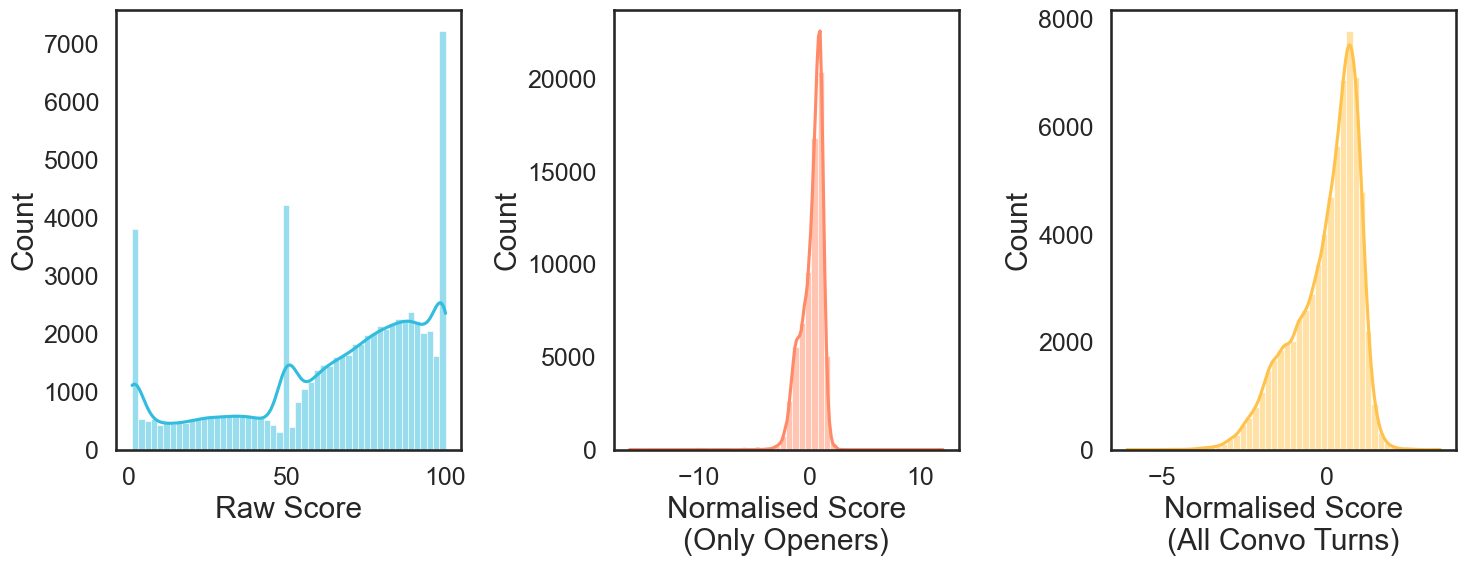

In [4]:
# Plot distribution
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
sns.histplot(
    data_dict["utterances"],
    x="score",
    bins=50,
    kde=True,
    ax=ax[0],
    color=basic_colors_dict["blue"],
)
ax[0].set_xlabel("Raw Score")
sns.histplot(
    data_dict["utterances"],
    x="normalized_score_openers",
    bins=50,
    kde=True,
    ax=ax[1],
    color=basic_colors_dict["red"],
)
ax[1].set_xlabel("Normalised Score\n(Only Openers)")
sns.histplot(
    data_dict["utterances"],
    x="normalized_score_full",
    bins=50,
    kde=True,
    ax=ax[2],
    color=basic_colors_dict["yellow"],
)
ax[2].set_xlabel("Normalised Score\n(All Convo Turns)")
plt.tight_layout()
# Save
plt.savefig(
    f"{PLOT_PATH}/score_distributions_raw_vs_normalised.pdf",
    format="pdf",
    bbox_inches="tight",
)
plt.show()

### Pivoting to Wide

In [5]:
interactions = pivot_to_wide_format(data_dict["utterances"].copy())
data_dict["interactions"] = interactions

In [6]:
display(interactions.head(4))
print(interactions.shape)

,interaction_id,conversation_id,turn,user_prompt,user_id,utterance_id_a,utterance_id_b,utterance_id_c,utterance_id_d,within_turn_id_a,...,normalized_score_openers_c,normalized_score_openers_d,normalized_score_full_a,normalized_score_full_b,normalized_score_full_c,normalized_score_full_d,within_turn_rank_a,within_turn_rank_b,within_turn_rank_c,within_turn_rank_d
0,int0,c0,0,What can you do about the inequality of wealth?,user0,ut0,ut1,NaN,NaN,0.0,...,NaN,NaN,-2.615421,1.106715,NaN,NaN,2.0,1.0,NaN,NaN
1,int1,c0,1,When can you do something?,user0,ut2,ut3,NaN,NaN,0.0,...,NaN,NaN,0.263031,0.362288,NaN,NaN,2.0,1.0,NaN,NaN
2,int10,c100,0,How can I improve communication with my boyfri...,user18,ut800,ut801,ut802,ut803,0.0,...,-0.350719,-0.845851,0.148532,0.729744,-0.658707,-1.175340,2.0,1.0,3.0,4.0
3,int100,c1024,0,what is the most perfect time to buy your wife...,user206,ut9250,ut9251,ut9252,ut9253,0.0,...,-0.303410,0.567245,0.960099,0.960099,-0.332401,0.548849,2.0,1.0,4.0,3.0


(27172, 53)


### Score by Turn

In [7]:
def calculate_turn_metrics(interactions, parent_metrics=["mean", "range"]):
    metrics = {
        "mean": [],
        "count": [],
        "range": [],
        "turn": [],
        "mean_std": [],
        "range_std": [],
    }

    for turn in interactions["turn"].unique():
        sub_df = interactions[interactions["turn"] == turn]

        if turn == 0:
            score_columns = ["score_a", "score_b", "score_c", "score_d"]
        else:
            score_columns = ["score_a", "score_b"]

        metrics["turn"].append(turn)

        # Calculate mean and standard deviation for each metric
        for metric in parent_metrics:
            if metric == "range":
                mean_val = sub_df["range"].mean()
                std_val = sub_df["range"].std()
            elif metric == "std_dev":
                mean_val = sub_df[score_columns].std().mean()
                std_val = sub_df[score_columns].std().std()
            elif metric == "mean":
                mean_val = sub_df[score_columns].mean().mean()
                std_val = sub_df[score_columns].mean().std()

            metrics[metric].append(mean_val)
            metrics[f"{metric}_std"].append(std_val)

        metrics["count"].append(len(sub_df))

    turn_metric_df = pd.DataFrame(metrics)

    return turn_metric_df

In [8]:
def plot_turn_metrics(turn_metric_df, parent_metrics):
    palette = get_equally_spaced_colors(palettes_dict["roma"], 2)
    palette = [basic_colors_dict["red"], basic_colors_dict["blue"]]
    markers = ["o", "s"]

    # Plotting
    fig, ax = plt.subplots(figsize=(14, 6))
    for i, metric in enumerate(parent_metrics):  # Only these metrics have std
        color = palette[i]
        # Adding shaded area for std
        ax.fill_between(
            turn_metric_df["turn"],
            turn_metric_df[metric] + turn_metric_df[f"{metric}_std"],
            turn_metric_df[metric] - turn_metric_df[f"{metric}_std"],
            color=color,
            alpha=0.3,
            edgecolor=None,
        )
        ax.plot(
            turn_metric_df["turn"],
            turn_metric_df[metric],
            label=metric.capitalize(),
            color=color,
            linestyle="-",
            linewidth=2,
            marker=markers[i],
        )

    # Plot count on secondary axis
    ax2 = ax.twinx()
    ax2.plot(
        turn_metric_df["turn"],
        turn_metric_df["count"],
        color=basic_colors_dict["darkgrey"],
        linestyle="-",
        marker="X",
        linewidth=2,
    )

    # Legend
    handles, labels = ax.get_legend_handles_labels()
    labels = [label.replace("_", " ") for label in labels]
    (count_line,) = ax2.plot(
        [],
        [],
        color=basic_colors_dict["darkgrey"],
        linestyle="-",
        marker="X",
        linewidth=2,
    )
    handles.append(count_line)
    labels.append("Count (secondary)")
    ax.legend(
        handles,
        labels,
        loc="upper center",
        ncols=4,
        bbox_to_anchor=(0.5, 1.15),
        fancybox=True,
        fontsize=14,
    )

    # Axis labels
    ax.set_xlabel("Conversation Turn", fontsize=20)
    ax.set_ylabel("Score (Raw)", fontsize=20)
    ax2.set_ylabel("Conversation Count", fontsize=20)
    # Add vline
    ax.axvline(
        x=1, color=basic_colors_dict["darkgrey"], linestyle=":", alpha=1, linewidth=5
    )
    ax.text(
        2,
        0.5,
        "Convo\ncontinues",
        fontsize=16,
        fontweight="semibold",
        color=basic_colors_dict["darkgrey"],
        va="center",
        ha="center",
    )
    ax.text(
        0.25,
        0.5,
        "Convo\nopens",
        fontsize=16,
        fontweight="semibold",
        color=basic_colors_dict["darkgrey"],
        va="center",
        ha="center",
    )

    # Save
    plt.tight_layout()
    plt.savefig(f"{PLOT_PATH}/metrics_by_turn.pdf", bbox_inches="tight", format="pdf")

    plt.show()

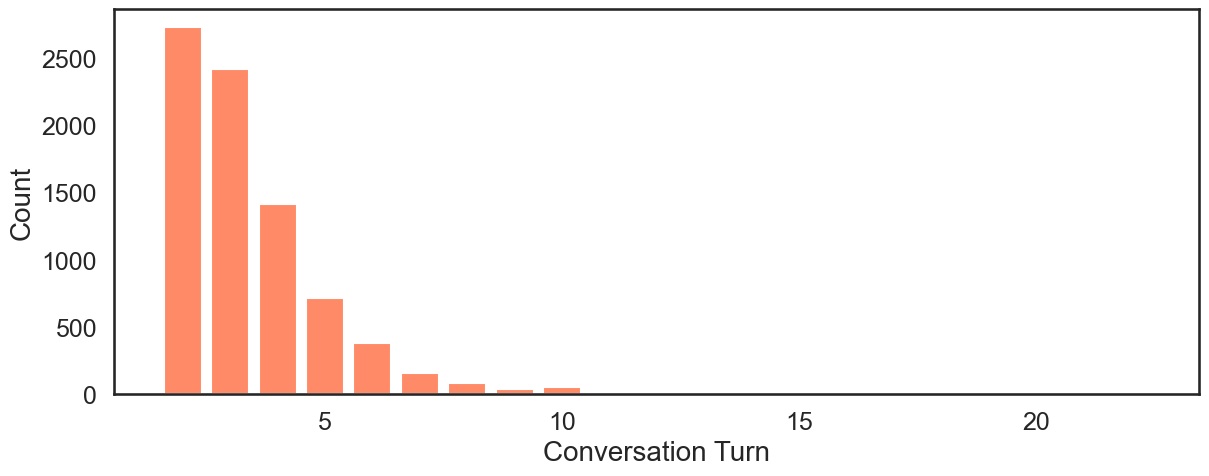

In [9]:
# Plot turn value counts
turn_value_counts = (
    data_dict["conversations"]["conversation_turns"].value_counts().sort_index()
)
fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(turn_value_counts.index, turn_value_counts.values)
ax.set_xlabel("Conversation Turn", fontsize=20)
ax.set_ylabel("Count", fontsize=20)
plt.show()

In [10]:
# For each number of turns, check how many unique users have conversations that long
unique_users = interactions.groupby("user_id")["turn"].max() + 1
unique_users = unique_users.value_counts().sort_index()
print(unique_users)

turn
2      74
3     264
4     327
5     281
6     186
7     110
8      59
9      35
10     40
11      9
12      5
13      5
22      1
Name: count, dtype: int64


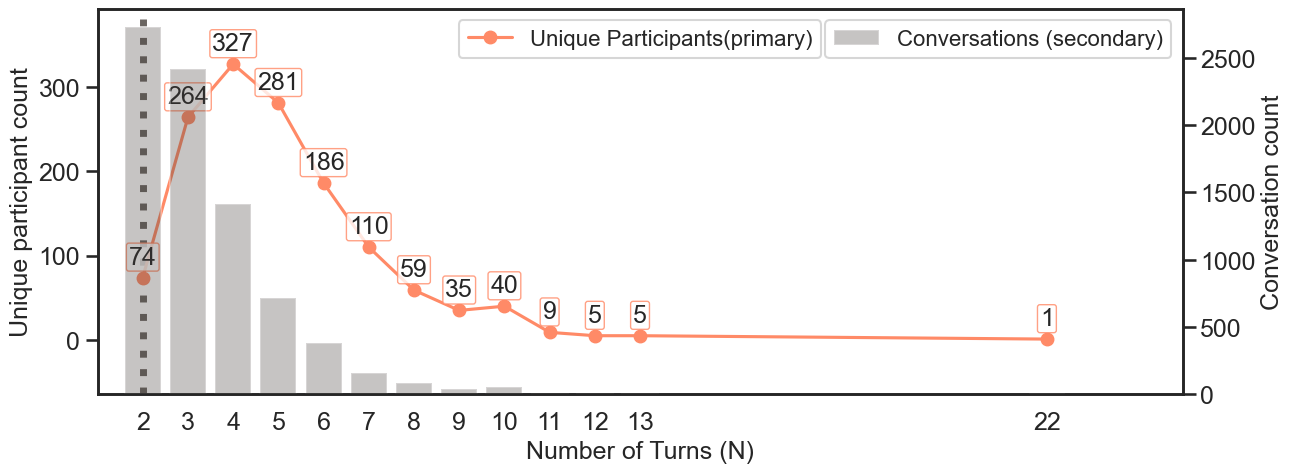

In [11]:
# Plot turn number and nunique users with convos of that length as line plot
fig, ax = plt.subplots(figsize=(14, 5))
ax.plot(unique_users.index, unique_users.values, marker="o")
ax.set_xlim(0, 23)
ax.set_xlabel("Number of Turns (N)", fontsize=18)
ax.set_ylabel("Unique participant count", fontsize=18)
# Label each point
for i, txt in enumerate(unique_users.values):
    ax.annotate(
        txt,
        (unique_users.index[i], unique_users.values[i]),
        textcoords="offset points",
        xytext=(0, 10),
        ha="center",
        bbox=dict(
            boxstyle="round,pad=0.1",
            fc="white",
            ec=basic_colors_dict["red"],
            alpha=0.8,
            lw=1,
        ),
    )
# Pad the axis
ax.margins(x=0.1, y=0.2)
# Vertical line at turn 1
ax.axvline(
    x=2,
    color=basic_colors_dict["darkgrey"],
    linestyle=":",
    alpha=0.8,
    linewidth=5,
    zorder=0,
)

# On secondary axis, plot the number of turns
ax2 = ax.twinx()
ax2.bar(
    turn_value_counts.index,
    turn_value_counts.values,
    color=basic_colors_dict["darkgrey"],
    alpha=0.3,
)
ax2.set_ylabel("Conversation count", fontsize=18)

# Set xlim
ax2.set_xlim(1, 25)
# Label every tick
ax2.set_xticks(turn_value_counts.index)

# Add legend
ax.legend(["Unique Participants(primary)"], loc="upper center", fontsize=16)
ax2.legend(["Conversations (secondary)"], loc="upper right", fontsize=16)

plt.savefig(f"{PLOT_PATH}/counts_by_turn.pdf", bbox_inches="tight", format="pdf")

plt.show()

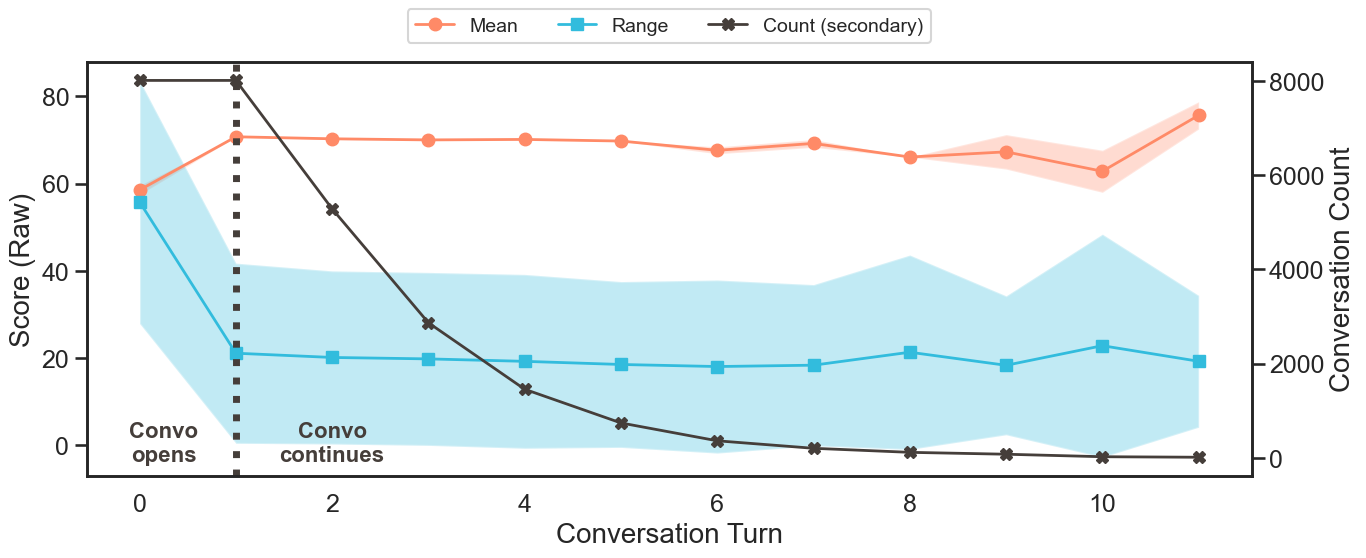

In [12]:
# Cut to 12 max (very few users after that)
filtered_interactions = interactions[interactions["turn"] < 12]
filtered_interactions = filtered_interactions.copy()
score_columns = ["score_a", "score_b", "score_c", "score_d"]
filtered_interactions["range"] = np.abs(
    filtered_interactions[score_columns].max(axis=1)
    - filtered_interactions[score_columns].min(axis=1)
)
filtered_interactions["max"] = filtered_interactions[score_columns].max(axis=1)
filtered_interactions["min"] = filtered_interactions[score_columns].min(axis=1)
filtered_interactions["mean"] = filtered_interactions[score_columns].mean(axis=1)
parent_metrics = ["mean", "range"]
turn_metric_df = calculate_turn_metrics(filtered_interactions, parent_metrics)

plot_turn_metrics(turn_metric_df, parent_metrics)

### Expressivity and Centrality

In [13]:
# Calculate Expressivity (Range and Standard Deviation)
def get_scale_analysis(df, score_columns):

    df["score_range"] = df[score_columns].max(axis=1) - df[score_columns].min(axis=1)
    df["score_std_dev"] = df[score_columns].std(axis=1)

    # Calculate Neutrality (Mean Score)
    midpoint = 50  # Adjust this based on your scale
    df["mean_score"] = df[score_columns].mean(axis=1)
    df["deviation_from_midpoint"] = abs(df["mean_score"] - midpoint)

    # Group by user and calculate average expressivity and neutrality
    user_analysis = df.groupby("user_id").agg(
        {
            "score_range": "mean",
            "score_std_dev": "mean",
            "mean_score": "mean",
            "deviation_from_midpoint": "mean",
        }
    )

    return user_analysis

In [14]:
def plot_histogram(data, subplot_index, title, color, vline_x, vline_color):
    plt.subplot(2, 2, subplot_index)
    sns.histplot(data, kde=True, color=color)
    plt.axvline(x=vline_x, color=vline_color, linestyle="--")
    plt.title(title)
    plt.xlabel("")
    plt.ylabel("Frequency")


def plot_summary_histograms(user_analysis):
    plt.figure(figsize=(12, 6))
    colors = get_equally_spaced_colors(palettes_dict["roma"], 2)

    # Looping through the DataFrame columns
    for index, (column_name, data) in enumerate(user_analysis.items(), 1):
        if index <= 2:
            header = "Expressivity"
            color = colors[0]
        else:
            header = "Centrality"
            color = colors[1]
        title = f'{header}: {column_name.replace("_", " ").title()}'
        vline_x = 0 if column_name == "deviation_from_midpoint" else 50
        plot_histogram(
            data, index, title, color, vline_x, basic_colors_dict["darkgrey"]
        )

        if index == 4:
            break  # To ensure we only plot for the first four columns

    plt.tight_layout()
    plt.show()


def plot_joint_plot(user_analysis, run_name):
    # Joint plot
    ax = sns.jointplot(
        x="score_range",
        y="mean_score",
        data=user_analysis,
        kind="hex",
        cmap=palettes_dict["roma"].reversed(),
        joint_kws=dict(gridsize=20),
    )
    colors = get_equally_spaced_colors(palettes_dict["roma"], 2)
    # Change color
    plt.setp(ax.ax_marg_x.patches, color=colors[0], edgecolor=basic_colors_dict["oat"])
    plt.setp(ax.ax_marg_y.patches, color=colors[1], edgecolor=basic_colors_dict["oat"])
    # Set labels for the axes
    ax.set_axis_labels("Expressivity (Score Range)", "Centrality (Mean Score)")

    # Save
    plt.savefig(
        f"{PLOT_PATH}/scale_jointplot_{run_name}.pdf", bbox_inches="tight", format="pdf"
    )
    plt.show()


def run_score_analysis(df, score_columns, run_name):
    user_analysis = get_scale_analysis(df, score_columns)
    means = user_analysis.mean()
    # Convert the Series to DataFrame
    means_df = pd.DataFrame(means).transpose()
    means_df["Description"] = run_name
    cols = means_df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    means_df = means_df[cols]
    plot_summary_histograms(user_analysis)
    plot_joint_plot(user_analysis, run_name)
    return means_df

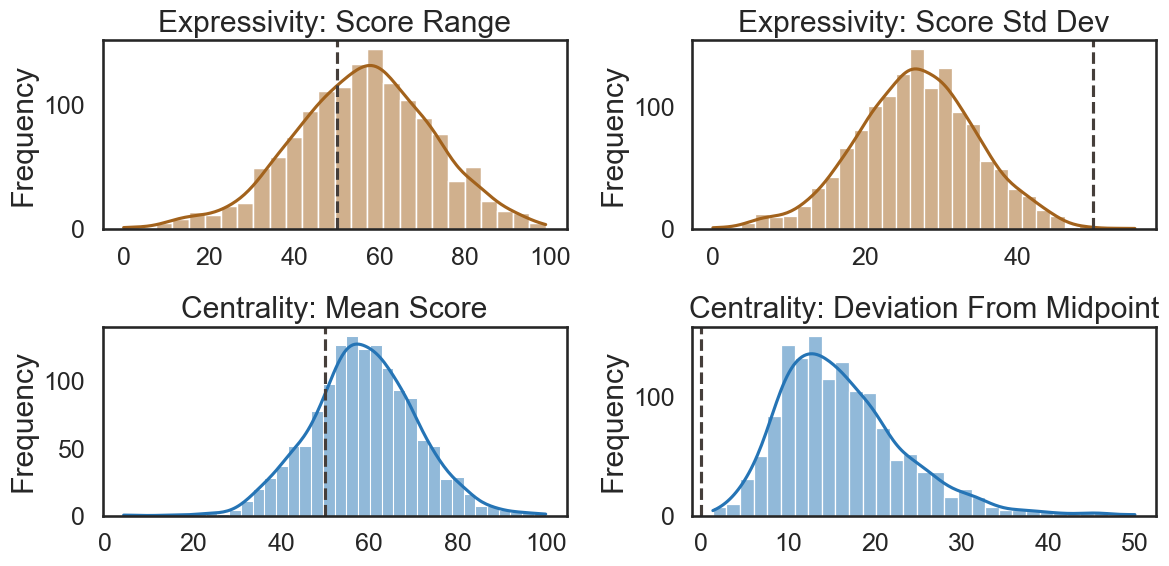

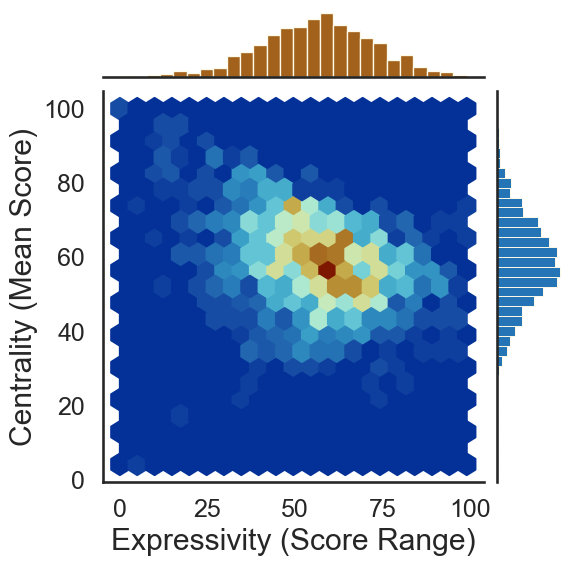

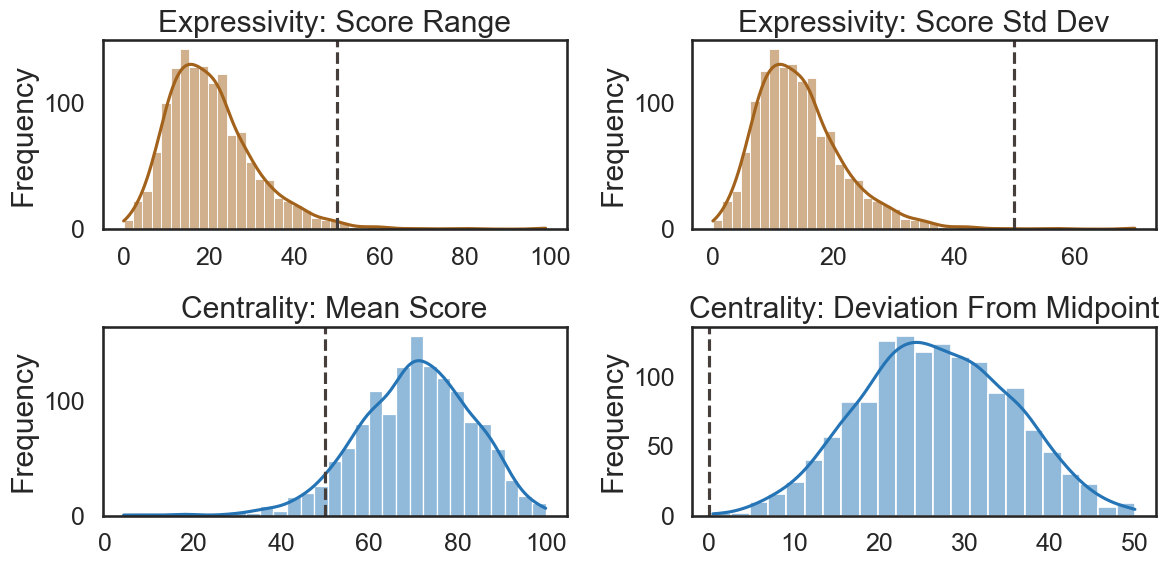

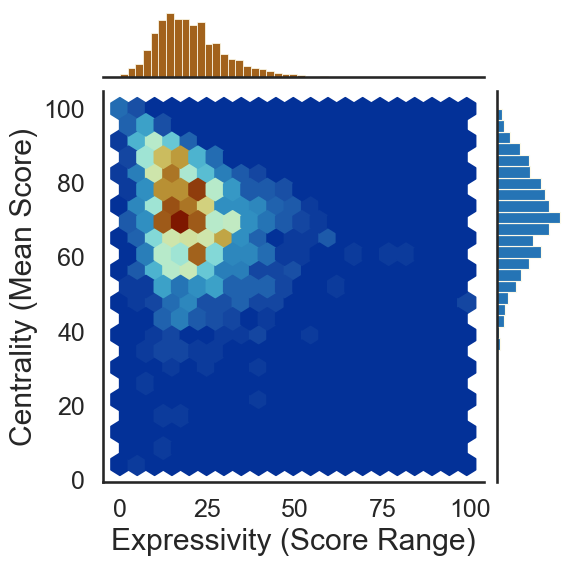

In [15]:
summary_df = pd.DataFrame()
colors = get_equally_spaced_colors(palettes_dict["roma"], 3)
all_turns = interactions.copy()
openers = all_turns[all_turns["turn"] == 0].copy()
continuers = all_turns[all_turns["turn"] > 0].copy()
for mode_df, mode in zip([openers, continuers], ["openers", "continuers"]):
    score_columns = ["score_a", "score_b", "score_c", "score_d"]
    means_df = run_score_analysis(mode_df, score_columns, mode)
    summary_df = pd.concat([summary_df, means_df], ignore_index=True)

### Across Group Differences in Scores

['Male', 'Female', 'Non-binary']
['25-34', '18-24', '35-44', '45-54', '55-64', '65+']
['White', 'Black', 'Hispanic', 'Asian', 'Mixed', 'Other']
['No Affiliation', 'Christian', 'Jewish', 'Muslim', 'Other']
['US', 'Europe', 'UK', 'Latam', 'Aus & NZ', 'Africa', 'Asia', 'N. America', 'Middle East']


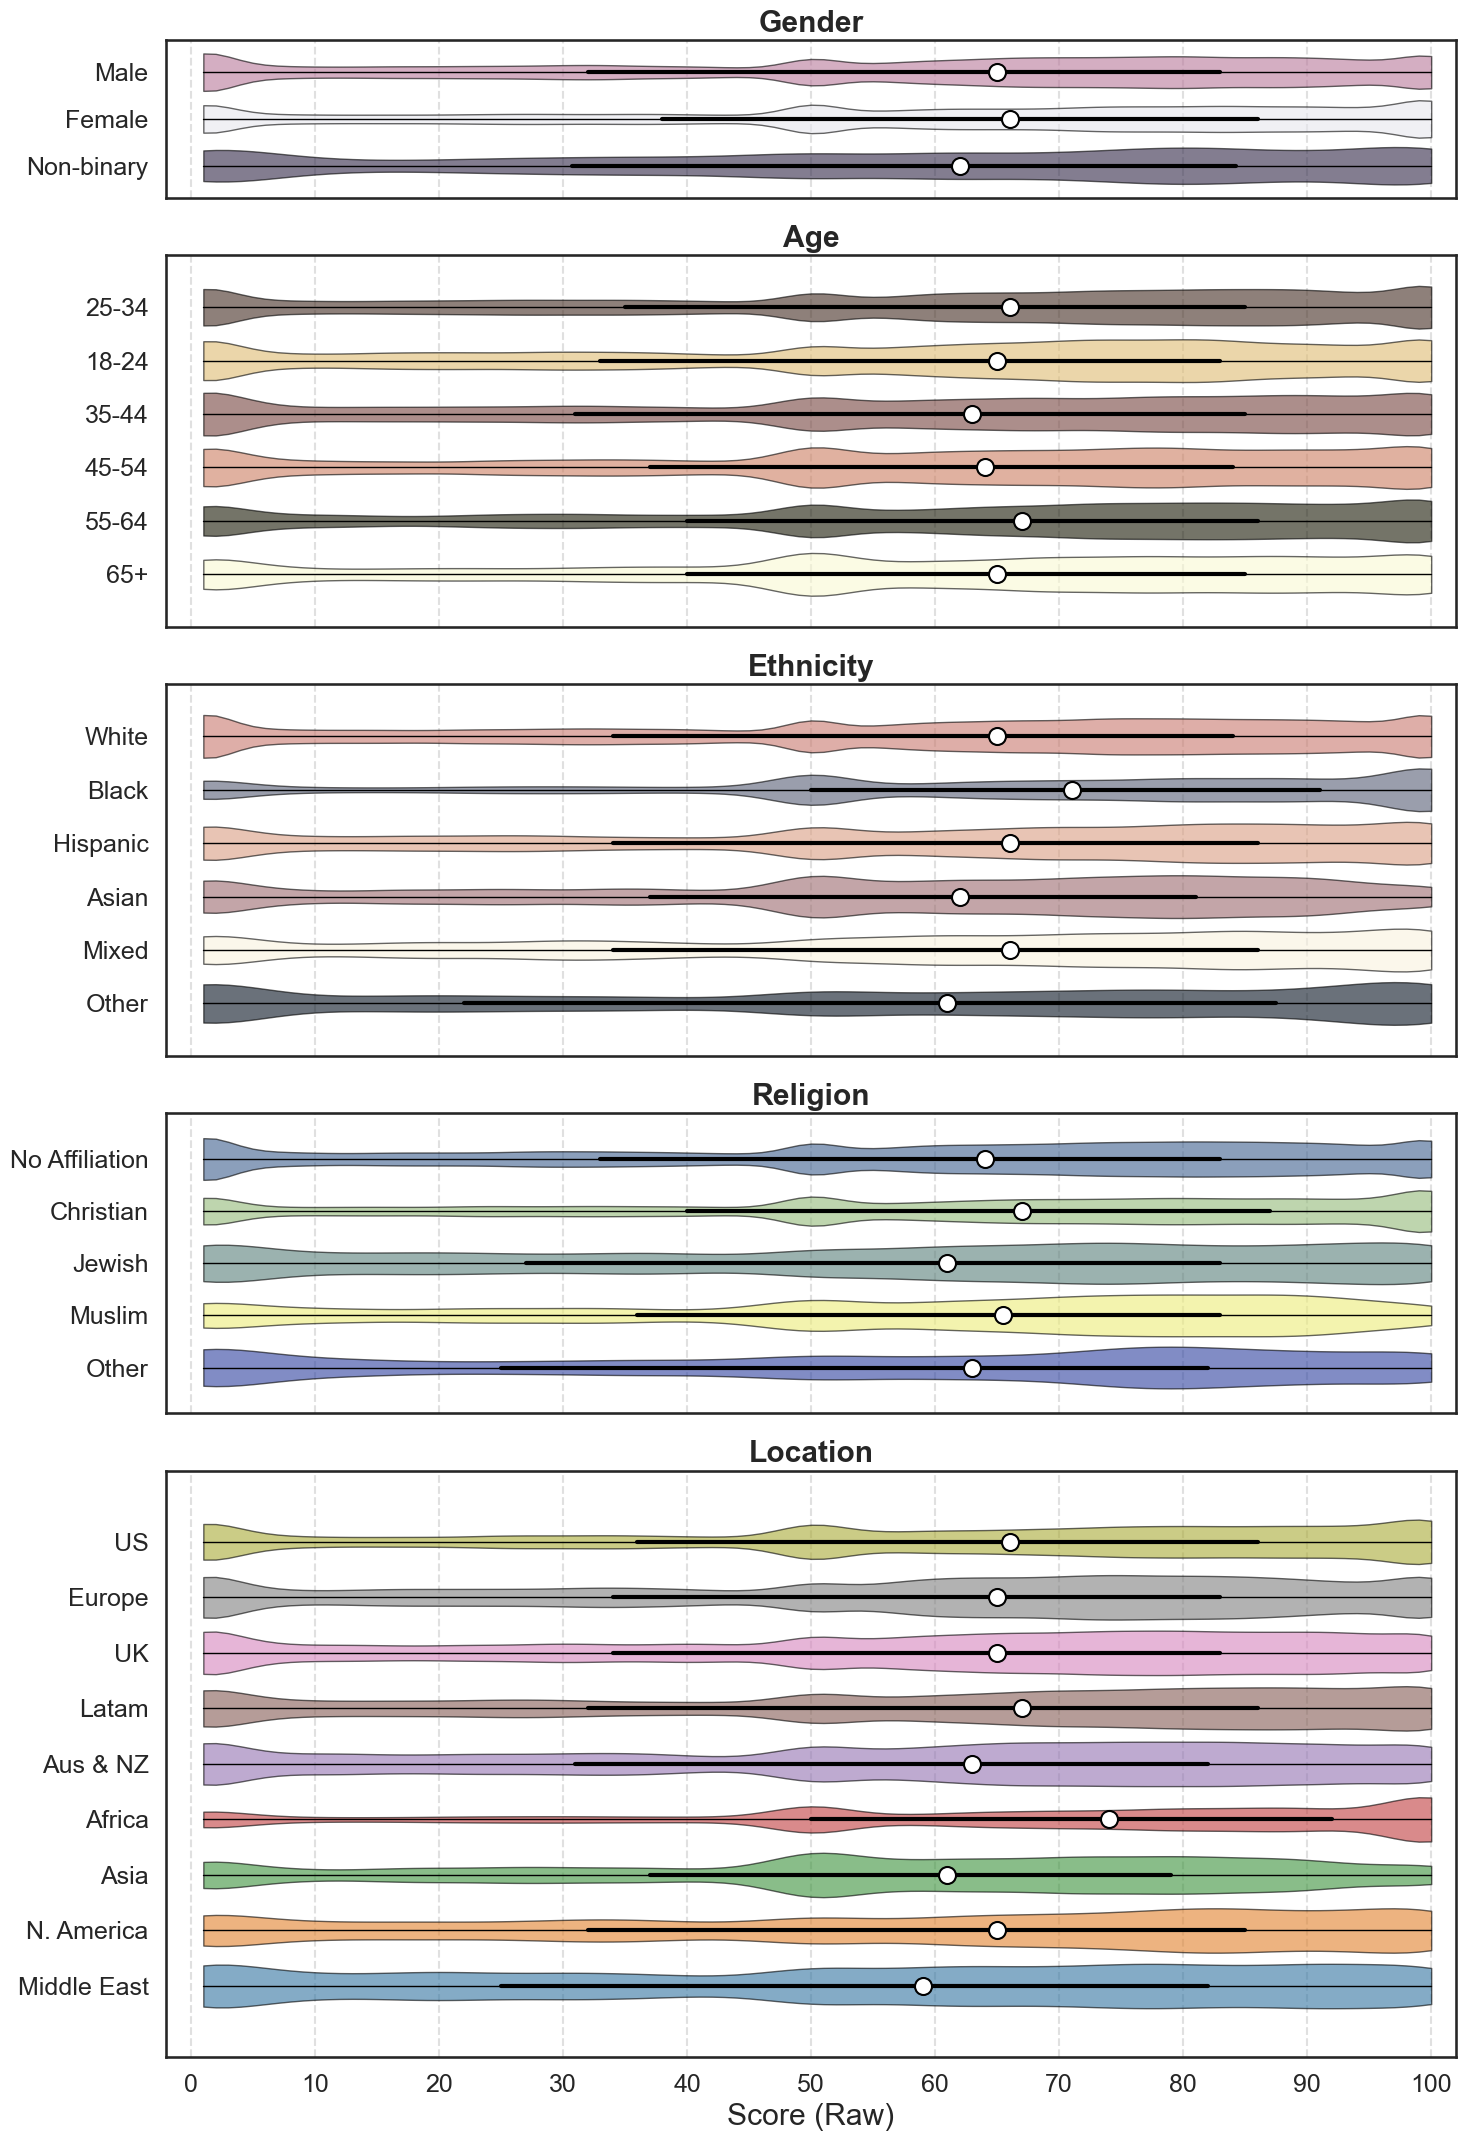

In [16]:
merged = utterances.merge(survey, on="user_id", how="left")
df = merged[merged["turn"] == 0]
plot_col = "score"


THRESH = 20

demo_cols = [
    "gender",
    "age",
    "ethnicity_simplified",
    "religion_simplified",
    "location_special_region",
]


# SET UP GROUPS
total_rows = 0
filtered_df = df.copy()
for i, demo in enumerate(demo_cols):
    # Filter by thresh
    for s in df[demo].unique():
        if s == "Prefer not to say":
            filtered_df = filtered_df[filtered_df[demo] != s]
        n_unique_members = df[df[demo] == s]["user_id"].nunique()
        if n_unique_members < THRESH:
            filtered_df = filtered_df[filtered_df[demo] != s]
    # Rename the groups within each demo column
    filtered_df[demo] = filtered_df[demo].map(
        lambda x: demo2label[demo][x] if x in demo2label[demo] else x
    )
    subgroups_count = filtered_df[demo].nunique()
    total_rows += subgroups_count

# Create figure and GridSpec with calculated total rows
fig = plt.figure(figsize=(15, 0.75 * total_rows))  # Adjust width and height as needed
gs = gridspec.GridSpec(total_rows, 1)

# PLOT
current_row = 0
for i, demo in enumerate(demo_cols):
    # Find the order
    my_order = filtered_df.groupby(by=[demo])[plot_col].median().iloc[::-1].index

    # Get color mapping
    subgroups = filtered_df[demo].unique()
    subgroups_count = len(subgroups)
    colors = [demo2color[demo][s] for s in subgroups]
    # Create subplot in the next available row(s) based on the number of subgroups
    ax = fig.add_subplot(gs[current_row : current_row + subgroups_count, 0])
    current_row += subgroups_count  # Update current row for the next subplot

    # Reverse
    my_order = list(demo2color[demo].keys())[::-1]
    print(my_order)
    # Horizontal violin plot
    sns.violinplot(
        y=demo,
        x=plot_col,
        hue=demo,
        order=my_order,
        data=filtered_df,
        ax=ax,
        palette=colors,
        linewidth=1,
        edgecolor="black",
        alpha=0.6,
        inner="box",
        bw_adjust=0.5,
        inner_kws={
            "marker": "o",
            "box_width": 3,
        },
        cut=0,
    )

    # Plot medians as points
    medians = filtered_df.groupby(demo)[plot_col].median()
    x = [medians[s] for s in my_order]
    y = range(len(x))
    ax.scatter(x, y, color="white", s=150, zorder=3, edgecolor="black")

    # No y label
    ax.set_xlabel("Score (Raw)")
    ax.set_ylabel("")
    ax.set_title(f"{demo.split('_')[0].capitalize()}", fontweight="semibold")
    ax.set_xlim(-2, 102)
    ax.margins(0.1)
    # Turn off x label ticks if not bottom axis
    if current_row < total_rows:
        ax.set_xticklabels([])
        ax.set_xlabel("")
    # Grid lines every 10 points
    ax.set_xticks(np.arange(0, 101, 10))
    ax.grid(axis="x", linestyle="--", alpha=0.6)


# Adjust vertical space
plt.subplots_adjust(hspace=1)


plt.tight_layout()

# Save
plt.savefig(f"{PLOT_PATH}/score_dist_by_group.pdf", bbox_inches="tight", format="pdf")
plt.show()